In [1]:
# nts: activate langchain_env 
import cdsapi
import logging
from tqdm import tqdm
import xarray as xr
import numpy as np
import pandas as pd
import os
import sys
import contextlib
import threading

trackspath='/home/sonia/mcms/tracker/1940-2010/era5/read_era5/out_era5_output_1940_2010.txt'
# trackspath='/home/sonia/mcms/tracker/2010-2024/era5/out_era5/era5/mcms_era5_2010_2024_tracks.txt'
use_slp = False # whether to include slp channel
threads = 32

In [3]:
regmask = xr.open_dataset('/home/cyclone/regmask_0723_anl.nc')
# regmask.sel(lono=-178.8, lato=-87, method='nearest')['regmaskoc'].values

In [4]:
# atlantic ocean is regmask['reg_name'].values[109] # so 110 in regmaskoc values
reg_id = 110

In [5]:
# make dataframe of all tracks 
tracks = pd.read_csv(trackspath, sep=' ', header=None, 
        names=['year', 'month', 'day', 'hour', 'total_hrs', 'unk1', 'unk2', 'unk3', 'unk4', 'unk5', 'unk6', 
               'z1', 'z2', 'unk7', 'tid', 'sid'])
tracks = tracks.sort_values(by=['year', 'month', 'day', 'hour'])
tracks['lat'] = 90-tracks['unk1'].values/100
tracks['lon'] = tracks['unk2'].values/100
tracks = tracks[['year', 'month', 'day', 'hour', 'tid', 'sid', 'lat', 'lon']]
# tracks = tracks[tracks['year']<=1942] # for debugging
tracks

,year,month,day,hour,tid,sid,lat,lon
0,1940,1,1,0,19400101000110034050,19400101000110034050,79.02,340.65
6,1940,1,1,0,19400101000140017350,19400101000140017350,76.13,173.53
12,1940,1,1,0,19400101000150027900,19400101000150027900,74.89,278.86
22,1940,1,1,0,19400101000195000700,19400101000195000700,70.54,7.21
38,1940,1,1,0,19400101000350004550,19400101000350004550,55.08,45.59
...,...,...,...,...,...,...,...,...
3112943,2010,12,31,18,20101231181610016250,20101230061565015400,-71.01,162.31
3112950,2010,12,31,18,20101231181635023250,20101230061635023250,-73.33,232.30
3112962,2010,12,31,18,20101231180405018900,20101230120465017150,49.33,189.18
3112968,2010,12,31,18,20101231181740027150,20101230121740027150,-84.06,271.39


In [8]:
get_lon_half_deg(lat, lon_half_deg_equator)

8.000000487387897

In [76]:
sids = tracks[tracks['tid'] == tracks['sid']]
natlantic = 0
for _, sid in sids.iterrows():
    if sid['lat'] > 0 and 110 in regmask.sel(lono=sid['lon'], lato=sid['lat'], method='nearest')['regmaskoc'].values:
        natlantic += 1
natlantic

3312

In [3]:
@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

In [4]:
box = 32 # (box/2 from center in each direction)
if use_slp:
    file_year = 1940
    slp = xr.open_dataset('/home/cyclone/slp.1940.nc')
    slp_next = xr.open_dataset('/home/cyclone/slp.1941.nc')
with suppress_output():
    client = cdsapi.Client()

def prep_point(df, thread=0):
    """make one training datapoint. df contains year/../hr, lat, lon of center"""
    boxes = []
    for _, frame in df.iterrows():
        year, month, day, hour = frame['year'], frame['month'], frame['day'], frame['hour']
        lat, lon = frame['lat'], frame['lon']
        if use_slp:
            # get the box
            if year==file_year:
                slp_box = slp.sel(time=f'{year}-{month:02d}-{day:02d}T{hour:02d}:00:00',
                                lat=slice(lat+box/4, lat-box/4), lon=slice(lon-box/4, lon+box/4))
                                # /4, because /2 for half box and /2 for grid resolution of 0.5 degrees
            elif year==file_year+1:
                slp_box = slp_next.sel(time=f'{year}-{month:02d}-{day:02d}T{hour:02d}:00:00', 
                                lat=slice(lat+box/4, lat-box/4), lon=slice(lon-box/4, lon+box/4))
            else:
                raise ValueError(f'Year {year} not supported, file year is {file_year}')
            slp_box = slp_box.slp.squeeze().values
        
        request = {
            "product_type": ["reanalysis"],
            "variable": [
                "10m_u_component_of_wind",
                "10m_v_component_of_wind",
                # "sea_surface_temperature"
            ],
            "year": [str(year)],
            "month": [str(month)],
            "day": [str(day)],
            "time": [f"{hour}:00"],
            'format': 'netcdf',
            "download_format": "unarchived",
            "area": [lat+box/4, lon-box/4, lat-box/4, lon+box/4],
            'grid': '0.5/0.5', 
        }
        with suppress_output():
            out = client.retrieve('reanalysis-era5-single-levels', request, f'temp_{str(thread)}.nc') #.download()

        ds = xr.open_dataset('temp.nc')
        u = ds['u10'].squeeze().values[:box, :box] # deal with rounding things
        v = ds['v10'].squeeze().values[:box, :box]
        magnitude = np.sqrt(u**2 + v**2)
        boxes.append(magnitude)
        
    return boxes

In [36]:
sids = tracks['sid'].unique()
RADIUS=6371 # Earth radius in km
outpath = '/home/cyclone/train/slp_small'
if not os.path.exists(outpath):
    os.makedirs(outpath)
readme = """small debugging dataset: 32x32 of just slp, 8 frames long, over [1940,1942]"""
with open(f'{outpath}/README.txt', 'w') as f:
    f.write(readme)

def worker(sids_chunk, thread_id):
    for i, sid in enumerate(sids_chunk):
        if i % 100 == 0:
            print(f'Thread {thread_id}: Processing sid {i}/{len(sids_chunk)}: {i//len(sids_chunk)*100:.2f}% complete')
        sid_df = tracks[tracks['sid'] == sid]
        if len(sid_df) < 10:
            continue
        elif sid_df[sid_df['tid']==sid]['lat'].abs().iloc[0] > 70:
            continue # starts poleward of 70 degrees
        elif sid_df[sid_df['tid']==sid]['lon'].iloc[0]<28 or sid_df[sid_df['tid']==sid]['lon'].iloc[0] >120:
            continue # only get indian ocean area

        sid_df = sid_df.sort_values(by=['tid'])
        
        # # check total distance traveled (sum of great circle)
        # lat1 = np.radians(sid_df['lat'].to_numpy()[:-1])
        # lon1 = np.radians(sid_df['lon'].to_numpy()[1])
        # lat2 = np.radians(sid_df['lat'].to_numpy()[1:])
        # lon2 = np.radians(sid_df['lon'].to_numpy()[1:])
        # dlat = lat2 - lat1
        # dlon = lon2 - lon1
        # a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        # c = 2 * np.arcsin(np.sqrt(a))
        # dist = np.sum(RADIUS * c)
        
        sid_df = sid_df.iloc[:8]  # only take the first 8 frames for debugging
        
        if use_slp and sid_df['year'].iloc[0] == file_year + 1: # starts in the next year
            slp = slp_next
            try:
                slp_next = xr.open_dataset(f'/home/cyclone/slp.{file_year+2}.nc')
            except:
                slp_next = None # reaching the end of our data
            file_year += 1 

        point = prep_point(sid_df)
        os.makedirs(f'{outpath}/{sid}', exist_ok=True)
        for i, frame in enumerate(point):
            np.save(f'{outpath}/{sid}/{i}.npy', frame)

In [ ]:
for i in range(threads):
    start = i * len(sids) // threads
    end = (i + 1) * len(sids) // threads
    sids_chunk = sids[start:end]
    print(start, end, sids_chunk.shape)
    thread = threading.Thread(target=worker, args=(sids_chunk, i))
    thread.start()
    # worker(sids_chunk, i)
    
for i in range(threads):
    thread.join()
print("All threads completed.")

In [48]:
from pyproj import Proj, Transformer
import numpy as np 
import xarray as xr 

ds = xr.open_dataset('/home/cyclone/slp/slp.1940.nc')

lat_center = 30.02
lon_center = 100.65
# 'aeqd': https://proj.org/en/stable/operations/projections/aeqd.html
proj_km = Proj(proj='aeqd', lat_0=lat_center, lon_0=lon_center, units='km')


In [49]:
# Define a rectangle in km around center (100 km east/west, 50 km north/south)
l = 850 #desired half-length in km
grid = 0.5
x_km = np.array([-l, l, l, -l])
y_km = np.array([-l, -l, l, l])

# Project to lat/lon
lonlat = proj_km(x_km, y_km, inverse=True)
lon_min = lonlat[0].min()#-grid
lon_max = lonlat[0].max()#+grid 
lat_min = lonlat[1].min()#-grid
lat_max = lonlat[1].max()#+grid
print('lat:', lat_center, (lat_min, lat_max), '\nlon:', lon_center, (lon_min, lon_max))
box = ds.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))
box

lat: 30.02 (22.094170690100132, 37.33838073294808) 
lon: 100.65 (91.07013239216361, 110.22986760783641)


<xarray.Dataset> Size: 7MB
Dimensions:  (time: 1464, lat: 30, lon: 38)
Coordinates:
    number   int64 8B ...
  * lat      (lat) float64 240B 37.0 36.5 36.0 35.5 35.0 ... 24.0 23.5 23.0 22.5
  * lon      (lon) float64 304B 91.5 92.0 92.5 93.0 ... 108.5 109.0 109.5 110.0
  * time     (time) datetime64[ns] 12kB 1940-01-01 ... 1940-12-31T18:00:00
Data variables:
    slp      (time, lat, lon) float32 7MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-07T19:33 GRIB to CDM+CF via cfgrib-0.9.1...

In [50]:
from shapely import Polygon, Point

poly = Polygon(list(zip(lonlat[0], lonlat[1])))
lats, lons = np.meshgrid(box.lat.values, box.lon.values, indexing='ij') # element ij gives the lat/lon at that point

# Create a mask: True where outside the polygon
mask = np.ones(lats.shape, dtype=bool)

# Vectorized loop (not the fastest, but clear)
for i in range(lats.shape[0]):
    for j in range(lats.shape[1]):
        point = Point(lons[i, j], lats[i, j])
        if poly.contains(point):
            mask[i, j] = False  # False means inside

In [51]:
masked_temp = box['slp'].where(~mask)  # now data outside polygon is NaN
masked_temp

<xarray.DataArray 'slp' (time: 1464, lat: 30, lon: 38)> Size: 7MB
array([[[1044.8217 , 1043.2992 , 1040.4496 , ..., 1030.8629 ,
         1030.3033 , 1030.4534 ],
        [1044.0692 , 1044.5762 , 1042.955  , ..., 1031.1549 ,
         1030.7904 , 1030.6576 ],
        [1045.6212 , 1045.4741 , 1045.3666 , ..., 1030.9863 ,
         1031.0304 , 1030.625  ],
        ...,
        [       nan,        nan, 1019.9583 , ...,        nan,
                nan,        nan],
        [       nan,        nan, 1019.7183 , ...,        nan,
                nan,        nan],
        [       nan,        nan, 1019.4899 , ...,        nan,
                nan,        nan]],

       [[1036.4541 , 1034.2264 , 1033.3707 , ..., 1027.3282 ,
         1026.762  , 1026.1049 ],
        [1037.1862 , 1035.7191 , 1035.2994 , ..., 1027.5919 ,
         1027.2015 , 1026.4894 ],
        [1038.722  , 1038.6124 , 1038.509  , ..., 1027.4966 ,
         1027.5511 , 1026.9545 ],
...
        [       nan,        nan, 1015.667  , ...,        nan,
                nan,        nan],
        [       nan,        nan, 1015.3836 , ...,        nan,
                nan,        nan],
        [       nan,        nan, 1015.2637 , ...,        nan,
                nan,        nan]],

       [[1011.4961 , 1008.5635 , 1008.93536, ..., 1016.877  ,
         1016.8723 , 1017.8631 ],
        [1013.43976, 1012.1992 , 1011.21094, ..., 1017.08673,
         1017.3913 , 1017.9184 ],
        [1021.33026, 1020.4041 , 1019.0638 , ..., 1017.6304 ,
         1018.10565, 1017.44476],
        ...,
        [       nan,        nan, 1015.54834, ...,        nan,
                nan,        nan],
        [       nan,        nan, 1015.2468 , ...,        nan,
                nan,        nan],
        [       nan,        nan, 1015.08795, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
    number   int64 8B ...
  * lat      (lat) float64 240B 37.0 36.5 36.0 35.5 35.0 ... 24.0 23.5 23.0 22.5
  * lon      (lon) float64 304B 91.5 92.0 92.5 93.0 ... 108.5 109.0 109.5 110.0
  * time     (time) datetime64[ns] 12kB 1940-01-01 ... 1940-12-31T18:00:00
Attributes:
    units:    mb

In [115]:
ds

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 1464, lat: 361, lon: 720)
Coordinates:
    number   int64 8B ...
  * lat      (lat) float64 3kB 90.0 89.5 89.0 88.5 ... -88.5 -89.0 -89.5 -90.0
  * lon      (lon) float64 6kB 0.0 0.5 1.0 1.5 2.0 ... 358.0 358.5 359.0 359.5
  * time     (time) datetime64[ns] 12kB 1940-01-01 ... 1940-12-31T18:00:00
Data variables:
    slp      (time, lat, lon) float32 2GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-07T19:33 GRIB to CDM+CF via cfgrib-0.9.1...

In [140]:
import numpy as np 
from pyproj import Proj 
import xarray as xr
from scipy.interpolate import RegularGridInterpolator

# load some example data to play with, define practice focus area
ds = xr.open_dataset('/home/cyclone/slp/slp.1940.nc')
resolution = 0.5
lat_center = 55.02
lon_center = 140.65

# Define projected x/y bounds in km (e.g., ±100 km, ±100 km around center)
l = 800 # half-length of a side of the box in km
s = 32 # box will be dimensions s by s (eg 32x32)
x_lin = np.linspace(-l, l, s)
y_lin = np.linspace(-l, l, s)
x_grid, y_grid = np.meshgrid(x_lin, y_lin) # equal-spaced points from -l to l in both x and y dimensions

# Azimuthal equidistant ('aeqd'): https://proj.org/en/stable/operations/projections/aeqd.html
proj_km = Proj(proj='aeqd', lat_0=lat_center, lon_0=lon_center, units='km') #lat center, lon center are (0,0) in the projected space
lon_grid, lat_grid = proj_km(x_grid, y_grid, inverse=True) #translate km to deg

lon_min = lon_grid.min() - resolution # +- reso because otherwise xarray will not include the edge points
lon_max = lon_grid.max() + resolution
lat_min = lat_grid.min() - resolution
lat_max = lat_grid.max() + resolution

subset = ds.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max), time='1940-12-31T18:00:00')['slp']
subset = subset.sortby(['lat', 'lon'])  # ensure lat/lon are sorted for interpolation

# Build interpolator
interp = RegularGridInterpolator(
    (subset.lat.values, subset.lon.values),
    subset.values,
    bounds_error=False,
    fill_value=np.nan
)

# Interpolate at new (lat, lon) pairs
interp_points = np.stack([lat_grid.ravel(), lon_grid.ravel()], axis=-1)
interp_values = interp(interp_points).reshape(32, 32)
subset.values.shape

(32, 62)

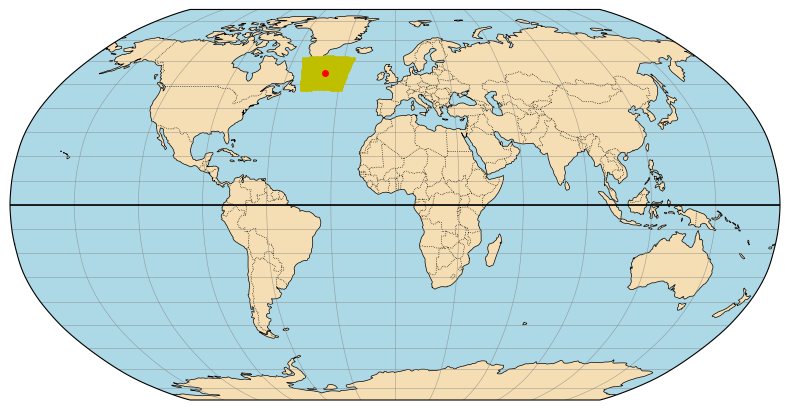

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

lat = lat_center
lon = lon_center - 180

fig = plt.figure(figsize=(8, 8))
# ax = plt.axes(projection=ccrs.Orthographic(central_longitude=-30, central_latitude=30))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.add_feature(cfeature.OCEAN.with_scale('110m'), facecolor='lightblue')
ax.add_feature(cfeature.LAND.with_scale('110m'), facecolor='wheat')
ax.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.5)
ax.add_feature(cfeature.BORDERS.with_scale('110m'), linestyle=':', linewidth=0.5)

# Gridlines (meridians and parallels)
meridians = np.arange(-180, 180, 30)
parallels = np.arange(-80, 90, 10)

# Draw meridians
for mer in meridians:
    ax.plot([mer]*181, np.linspace(-90, 90, 181),
            transform=ccrs.PlateCarree(), color='gray', linewidth=0.4, alpha=0.7)

# Draw parallels
for par in parallels:
    ax.plot(np.linspace(-180, 180, 361), [par]*361,
            transform=ccrs.PlateCarree(), color='gray', linewidth=0.4, alpha=0.7)

# Highlight equator in red
ax.plot(np.linspace(-180, 180, 361), [0]*361,
        transform=ccrs.PlateCarree(), color='black', linewidth=1.2)

# equal-area box coords
for i in range(interp_points.shape[0]):
        ax.plot(interp_points[i,1]-180, interp_points[i,0], 'yo', markersize=1, transform=ccrs.PlateCarree())

# Add red dot (center spot)
ax.plot(lon, lat, 'ro', markersize=4, transform=ccrs.PlateCarree())

plt.tight_layout()
plt.show()

In [162]:
lat_grid[-1,0], lon_grid[-1,0]-180, lat_grid[-1,-1], lon_grid[-1,-1]-180

(61.40380704005244, -54.420973092741335, 61.40380704005244, -24.27902690725864)

In [163]:
lat, lon

(55.02, -39.349999999999994)